```{index} single: AMPL; sets
```
```{index} single: AMPL; parameters
```
```{index} single: application; production planning
```
```{index} pandas dataframe
```

# Extra material: Multi-product facility production

In [1]:
# install dependencies and select solver
%pip install -q amplpy matplotlib

SOLVER = "highs"

from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["highs"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

Using default Community Edition License for Colab. Get yours at: https://ampl.com/ce
Licensed to AMPL Community Edition License for the AMPL Model Colaboratory (https://colab.ampl.com).


## Maximizing the profit in the worst case for a multi-product facility

A common formulation for the problem of maximizing profit of a multi-product facility in a resource constrained environment is given by the following LP

$$
\begin{align*}
\max\ \text{profit}  = \sum_{j\in J} c_j x_j &\\
\text{s.t.} \qquad \sum_{j\in J} a_{ij}x_j & \leq b_i & \forall \, i \in I\\
x_j & \geq 0 & \forall \, j\in J,
\end{align*}
$$

where $x_j$ is the production of product $j\in J$, $c_j$ is the net profit from producing and selling one unit of product $j$, $a_{i, j}$ is the amount of resource $i$ required to product a unit of product $j$, and $b_i$ is amount of resource $i\in I$ available. If this data is available, then the linear programming solution can provide a considerable of information regarding an optimal production plan and the marginal value of additional resources.

But what if coefficients of the model are uncertain? What should be the objective then? Does uncertainty change the production plan? Does the uncertainty change the marginal value assigned to resources? These are complex and thorny questions that will be largely reserved for later chapters of this book. However, it is possible to consider a specific situation within the current context.

Consider a situation where there are multiple plausible models for the net profit. These might be a result of marketing studies or from considering plant operation under multiple scenarios, which we collect in a set $S$. The set of profit models could be written

$$
\begin{align*}
\text{profit}_s & = \sum_{j} c_j^s x_j & \forall \, s\in S
\end{align*}
$$

where $s$ indexes the set of possible scenarios. The scenarios are all deemed equal, no probabilistic interpretation is given.

One conservative criterion is to find maximize profit for the worst case. Letting $z$ denote the profit for the worst case, this criterion requires finding a solution for ${x_j}$ for ${j\in J}$ that satisfies

$$
\begin{align*}
\max_{x_j} z & \\
\\
\text{s.t.} \qquad \sum_{j\in J} c_j^s x_j & \geq z& \forall \, s\in S\\
\sum_{j\in J} a_{ij}x_j & \leq b_i & \forall \, i \in I\\
x_j & \geq 0 & \forall \, j\in J
\end{align*}
$$

where $z$ is lowest profit that would be encountered under any condition.


## Data

In [10]:
import pandas as pd

BIM_scenarios = pd.DataFrame(
    [[12, 9], [11, 10], [8, 11]], columns=["product 1", "product 2"]
)

BIM_scenarios.index.name = "scenarios"
print("\nProfit scenarios")
display(BIM_scenarios)

BIM_resources = pd.DataFrame(
    [
        ["silicon", 1000, 1, 0],
        ["germanium", 1500, 0, 1],
        ["plastic", 1750, 1, 1],
        ["copper", 4000, 1, 2],
    ],
    columns=["resource", "available", "product 1", "product 2"],
)
BIM_resources = BIM_resources.set_index("resource")

print("\nAvailable resources and resource requirements")
display(BIM_resources)


Profit scenarios


product 1  product 2
scenarios                      
0                 12          9
1                 11         10
2                  8         11


Available resources and resource requirements


available  product 1  product 2
resource                                  
silicon         1000          1          0
germanium       1500          0          1
plastic         1750          1          1
copper          4000          1          2

## AMPL Model

An implementation of the maximum worst-case profit model.

In [11]:
%%writefile maxmin.mod

set I;
set J;
set S;

param a{I,J};
param b{I};
param c{S,J};

var x{J} >= 0;
var z;

maximize profit: z;
s.t. scenario_profit {s in S}: z <= sum{j in J} c[s, j] * x[j];
s.t. resource_limits {i in I}: sum{j in J} a[i, j] * x[j] <= b[i];

Overwriting maxmin.mod


In [12]:
def maxmin(scenarios, resources):
    products = resources.columns.tolist()
    products.remove("available")

    model = AMPL()
    model.read("maxmin.mod")

    model.set["I"] = resources.index.values
    model.set["J"] = products
    model.set["S"] = scenarios.index.values

    model.param["a"] = resources.drop("available", axis=1)
    model.param["b"] = resources["available"]
    model.param["c"] = scenarios

    return model


BIM = maxmin(BIM_scenarios, BIM_resources)
BIM.option["solver"] = SOLVER
BIM.solve()

worst_case_plan = pd.Series(BIM.var["x"].to_dict(), name="worst case")
worst_case_profit = BIM.obj["profit"].value()

print("\nWorst case profit =", worst_case_profit)
print(f"\nWorst case production plan:")
display(worst_case_plan)

HiGHS 1.5.3: HiGHS 1.5.3: optimal solution; objective 17500
3 simplex iterations
0 barrier iterations
 

Worst case profit = 17500.0

Worst case production plan:


product 1     583.333333
product 2    1166.666667
Name: worst case, dtype: float64

## Is maximizing the worst case a good idea?

Maximizing the worst case among all cases is a conservative planning outlook. It may be worth investigating alternative planning outlooks.

The first step is to create a model to optimize a single scenario. Without repeating the mathematical description, the following AMPL model is simply the `maxmin` model adapted to a single scenario.

In [13]:
%%writefile max_profit.mod

set I;
set J;

param a{I,J};
param b{I};
param c{J};

var x{J} >= 0;

maximize profit: sum{j in J} c[j] * x[j];
s.t. resource_limits {i in I}: sum{j in J} a[i, j] * x[j] <= b[i];

Overwriting max_profit.mod


In [14]:
def max_profit(scenario, resources):
    products = resources.columns.tolist()
    products.remove("available")

    model = AMPL()
    model.read("max_profit.mod")

    model.set["I"] = resources.index.values
    model.set["J"] = products

    model.param["a"] = resources.drop("available", axis=1)
    model.param["b"] = resources["available"]
    model.param["c"] = scenario

    return model

## Optimizing for the mean scenario

The next cell computes the optimal plan for the mean scenario.

In [15]:
# create mean scenario
mean_case = max_profit(BIM_scenarios.mean(), BIM_resources)
mean_case.option["solver"] = SOLVER
mean_case.solve()

mean_case_profit = mean_case.obj["profit"].value()
mean_case_plan = pd.Series(mean_case.var["x"].to_dict(), name="mean case")

print(f"\nMean case profit = {mean_case_profit:0.1f}")
print("\nMean case production plan:")
print(mean_case_plan)

HiGHS 1.5.3: HiGHS 1.5.3: optimal solution; objective 17833.33333
1 simplex iterations
0 barrier iterations
 

Mean case profit = 17833.3

Mean case production plan:
product 1    1000
product 2     750
Name: mean case, dtype: int64


The expected profit under the mean scenario if 17,833 which is 333 greater than for the worst case. Also note the production plan is different.

Which plan should be preferred? The one that produces a guaranteed profit of 17,500 under all scenarios, or one that produces expected profit of 17,833?

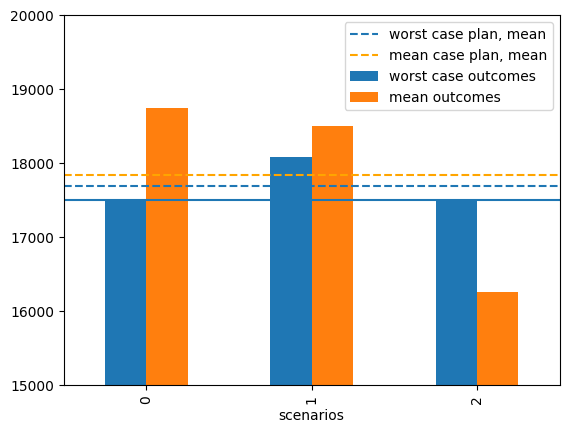

In [16]:
mean_case_outcomes = BIM_scenarios.dot(mean_case_plan)
mean_case_outcomes.name = "mean outcomes"

worst_case_outcomes = BIM_scenarios.dot(worst_case_plan)
worst_case_outcomes.name = "worst case outcomes"

ax = pd.concat([worst_case_outcomes, mean_case_outcomes], axis=1).plot(
    kind="bar", ylim=(15000, 20000)
)
ax.axhline(worst_case_profit)
ax.axhline(worst_case_outcomes.mean(), linestyle="--", label="worst case plan, mean")
ax.axhline(
    mean_case_outcomes.mean(),
    linestyle="--",
    color="orange",
    label="mean case plan, mean",
)
_ = ax.legend()

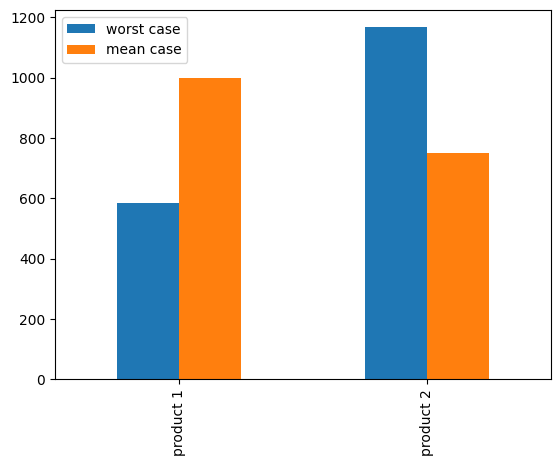

In [17]:
ax = pd.concat([worst_case_plan, mean_case_plan], axis=1).plot(kind="bar")

## Summary

Planning for the worst case reduces the penalty of a bad outcome. But it comes at the cost of reducing the expected payout, the also the maximum payout should the most favorable scenario occur.

1. Which plan would you choose.  Why?  

2. Make a case for the other choice.

